### 함수 API

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

In [4]:
model = keras.Sequential()
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [6]:
model.build(input_shape = (None, 3))
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[ 0.12631941,  0.25347167, -0.00488609,  0.26740915,  0.22867548,
         -0.14751908,  0.07992944,  0.23953146,  0.09696031,  0.2280212 ,
          0.07734424, -0.26015213,  0.24946028, -0.15875652, -0.2429674 ,
          0.17637363, -0.22110583, -0.27076757,  0.07575455,  0.03594947,
         -0.11252688, -0.2178421 , -0.10954341, -0.24971344,  0.1255131 ,
         -0.16324042, -0.09967086,  0.16210878, -0.13849406, -0.07798325,
          0.05194193, -0.23919475,  0.13705555, -0.12073255, -0.20201026,
         -0.11492451,  0.00728193,  0.04960352,  0.24845022,  0.17498821,
          0.29083288,  0.16006446, -0.16752006,  0.01078367,  0.07841852,
          0.27574724, -0.25068963,  0.04853195,  0.267937  , -0.25517088,
          0.25740403,  0.07722908,  0.21769351, -0.13429292,  0.27579302,
         -0.01995581, -0.18196797, -0.2866761 ,  0.08160475, -0.13727424,
          0.2378689 ,  0.19645071,  0.26112

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [14]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape = (vocabulary_size,), name = 'title')
text_body = keras.Input(shape = (vocabulary_size,), name = 'text_body')
tags = keras.Input(shape = (num_tags,), name = 'tags')

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation = 'relu')(features)

priority = layers.Dense(1, activation = 'sigmoid', name = 'priority')(features)
department = layers.Dense(num_departments, activation = 'softmax', name = 'department')(features)

model = keras.Model(inputs = [title, text_body, tags],
                    outputs = [priority, department])

In [18]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size = (num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size = (num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size = (num_samples, num_tags))

priority_data = np.random.random(size = (num_samples, 1))
department_data = np.random.randint(0, 2, size = (num_samples, num_departments))

model.compile(optimizer = 'rmsprop',
              loss = {'priority' : 'mean_squared_error', 'department' : 'categorical_crossentropy'},
              metrics = {'priority' : ['mean_absolute_error'], 'department' : ['accuracy']})

model.fit({'title' : title_data, 'text_body' : text_body_data, 'tags' : tags_data},
          {'priority' : priority_data, 'department' : department_data},
          epochs = 1)

model.evaluate({'title' : title_data, 'text_body' : text_body_data, 'tags' : tags_data},
          {'priority' : priority_data, 'department' : department_data})

priority_preds, department_preds = model.predict(
    {'title' : title_data, 'text_body' : text_body_data, 'tags' : tags_data}
)

40/40 [==============================] - 0s 3ms/step


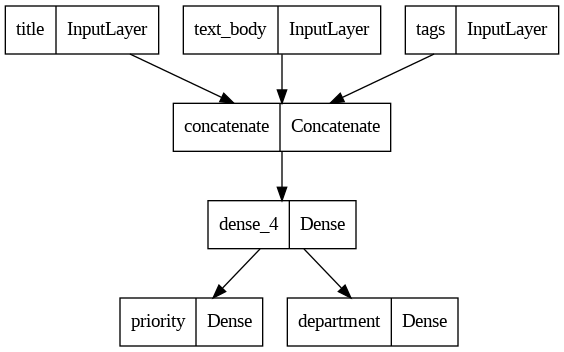

In [19]:
keras.utils.plot_model(model, 'ticket_classifier.png')

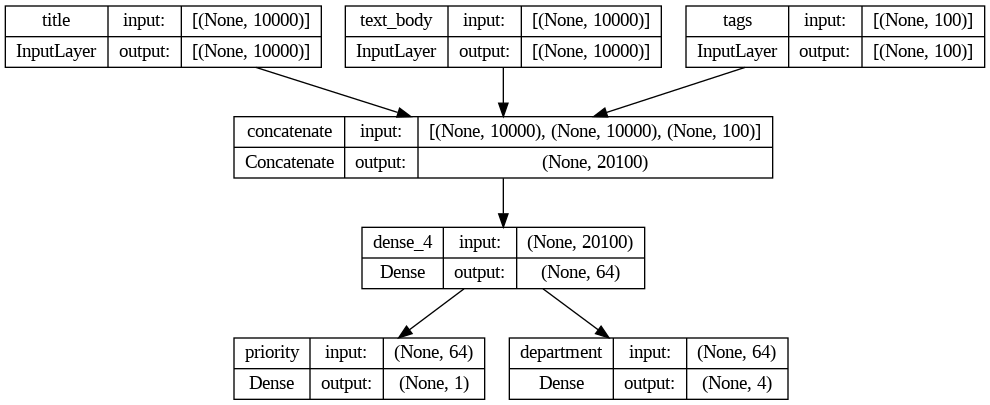

In [20]:
keras.utils.plot_model(
    model, 'ticket_classifier_with_shape_info.png', show_shapes = True
)

함수형 모델에 있는 층의 입력과 출력을 출력하기

In [21]:
model.layers

In [22]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [23]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

중간층의 출력을 재사용해서 새로운 모델 만들

In [24]:
model.layers[4].output

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_4')>

In [29]:
features = model.layers[4].output

difficulty = layers.Dense(3, activation = 'softmax', name = 'difficulty')(features)

new_model = keras.Model(
    inputs = [title, text_body, tags],
    outputs = [priority, department, difficulty]
)

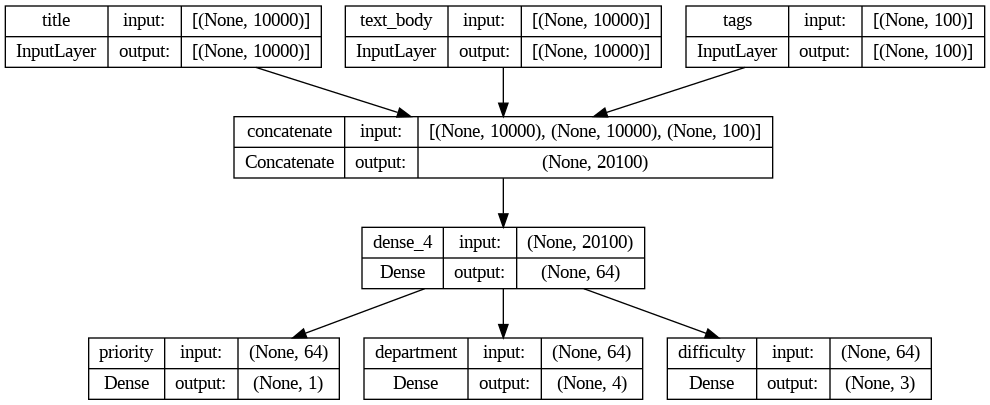

In [30]:
keras.utils.plot_model(
    new_model, 'updated_ticket_classifier.png', show_shapes = True
)

### model 서브 클래싱

In [35]:
class customerticketmodel(keras.Model) :
  def __init__(self, num_departments) :
    super().__init__()
    self.concat_layer = layers.Concatenate()
    self.mixing_layer = layers.Dense(64, activation = 'relu')
    self.priority_scorer = layers.Dense(1, activation = 'sigmoid')
    self.department_classifier = layers.Dense(
        num_departments, activation = 'softmax'
    )

  def call(self, inputs) :
    title = inputs['title']
    text_body = inputs['text_body']
    tags = inputs['tags']
    features = self.concat_layer([title, text_body, tags])
    features = self.mixing_layer(features)
    priority = self.priority_scorer(features)
    department = self.department_classifier(features)

    return priority, department

In [37]:
model = customerticketmodel(num_departments = 4)

priority, department = model(
    {'title' :  title_data, 'text_body' : text_body_data, 'tags' : tags_data}
)

In [39]:
model.compile(optimizer = 'rmsprop',
              loss = ['mean_squared_error', 'categorical_crossentropy'],
              metrics = [['mean_absolute_error'], ['accuracy']])

model.fit({'title' : title_data,
           'text_body' : text_body_data,
           'tags' : tags_data},
          [priority_data, department_data],
          epochs = 1)

model.evaluate({'title' : title_data,
                'text_body' : text_body_data,
                'tags' : tags_data},
                [priority_data, department_data])

priority_preds, department_preds = model.predict({'title' : title_data,
                                                  'text_body' : text_body_data,
                                                  'tags' : tags_data})


40/40 [==============================] - 0s 3ms/step


### 여러방식 혼합


In [44]:
class classifier(keras.Model) :

  def __init__(self, num_classes = 2) :
    super().__init__()

    if num_classes == 2 :
      num_units = 1
      activation = 'sigmoid'

    else :
      num_units = num_classes
      activation = 'softmax'

    self.dense = layers.Dense(num_units, activation = activation)

  def call(self, inputs) :

    return self.dense(inputs)

inputs = keras.Input(shape = (3,))
features = layers.Dense(64, activation = 'relu')(inputs)
outputs = classifier(num_classes = 10)(features)
model = keras.Model(inputs = inputs, outputs = outputs)

In [49]:
inputs = keras.Input(shape = (64))
outputs = layers.Dense(1, activation = 'sigmoid')(inputs)
binary_classifier = keras.Model(inputs = inputs, outputs = outputs)

class mymodel(keras.Model) :

  def __init__(self, num_classes = 2) :
    super().__init__()
    self.dense = layers.Dense(64, activation = 'relu')
    self.classifier = binary_classifier

  def call(self, inputs) :
    features = self.dense(inputs)

    return self.classifier(features)

model = mymodel()

### 내장된 훈련루프와 평가루프 사용하기

In [53]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
  inputs = keras.Input(shape = (28 * 28,))
  features = layers.Dense(512, activation = 'relu')(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, activation = 'softmax')(features)
  model = keras.Model(inputs, outputs)

  return model

(images, labels), (test_images, test_labels) = mnist.load_data()
# 28 * 28 = 784 픽셀의 1차원 배열로 평탄화 0 ~ 1사이로 정규화
# 완전 연결층은 각 입력 픽셀을 독립적인 특징으로 처리, 개별적으로 학습, 처리
images = images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') /255
train_images, val_images = images[10000 :], images[: 10000]
train_labels, val_labels = labels[10000 :], labels[: 10000]

model = get_mnist_model()
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy', # 원핫 인코딩 되지 않는 정수 레이블을 기대 정수값 1개
              metrics = ['accuracy'])
model.fit(train_images, train_labels,
          epochs = 3,
          validation_data = (val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predcitions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2960 - accuracy: 0.9115 - val_loss: 0.1456 - val_accuracy: 0.9577
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1627 - accuracy: 0.9525 - val_loss: 0.1148 - val_accuracy: 0.9670
Epoch 3/3
313/313 [==============================] - 0s 1ms/step


### 사용자 정의 지표 만들기

In [56]:
import tensorflow as tf

class rootmeansquarederror(keras.metrics.Metric) :
  def __init__(self, name = 'rmse', **kwargs) :
    super().__init__(name = name, **kwargs)

    self.mse_sum = self.add_weight(name = 'mse_sum', initializer = 'zeros')
    self.total_samples = self.add_weight(
        name = 'total_samples', initializer = 'zeros', dtype = 'int32'
    )

  def update_state(self, y_true, y_pred, sample_weight = None) :
    y_true = tf.one_hot(y_true, depth = tf.shape(y_pred)[1])
    mse = tf.reduce_sum(tf.square(y_true - y_pred))
    self.mse_sum.assign_add(mse)
    num_samples = tf.shape(y_pred)[0]
    self.total_samples.assign_add(num_samples)

  def result(self) :
    return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

  def reset_state(self) :
    self.mse_sum.assign(0.)
    self.total_samples.assign(0)


In [60]:
model = get_mnist_model()
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy', rootmeansquarederror()])

model.fit(train_images, train_labels,
          epochs = 3,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2941 - accuracy: 0.9127 - rmse: 7.1747 - val_loss: 0.1570 - val_accuracy: 0.9539 - val_rmse: 7.3524
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1578 - accuracy: 0.9540 - rmse: 7.3547 - val_loss: 0.1123 - val_accuracy: 0.9691 - val_rmse: 7.4042
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0908 - accuracy: 0.9751 - rmse: 7.4313
